# 1. SETTINGS

In [1]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr
import lightgbm as lgb
import random

In [2]:
# garbage collection
import gc
gc.enable()

In [3]:
# warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# pandas options
pd.set_option("display.max_columns", None)

# 2. IMPORT

In [5]:
# data name (used for saving files too)
data_name = "data_v4_0_60_under"

In [6]:
# import datasets
data = pd.read_csv("../data/prepared/" + str(data_name) + ".csv", compression = "gzip")

In [7]:
# data name (used for saving files too)
data_name = "data_v4_0_60_under_r27_wlp_lm_bm_rfr"

In [8]:
# drop high recency from train
data = data[(data.Week == 121) | (data.Recency2 < 27)]
data = data[(data.Week == 121) | (data.Recency1 < data.Recency1.max())]
print(data.shape)

(1696710, 45)


# 3. PREPARATIONS

### ADD MORE FEATURES

In [9]:
# compute BuySell dummy
data["Buy"] = 0
data["Buy"][data.BuySell == "Buy"] = 1
print(data.shape)

(1696710, 45)


In [10]:
### RF Ratios

data["R12_ratio"] = data.Recency1 / data.Recency2
data["R13_ratio"] = data.Recency1 / data.Recency3
data["R14_ratio"] = data.Recency1 / data.Recency4
data["R23_ratio"] = data.Recency2 / data.Recency3
data["R24_ratio"] = data.Recency2 / data.Recency4
data["R34_ratio"] = data.Recency3 / data.Recency4
data["R56_ratio"] = data.Recency5 / data.Recency6

data["F12_ratio"] = data.Frequency1 / data.Frequency2
data["F13_ratio"] = data.Frequency1 / data.Frequency3
data["F14_ratio"] = data.Frequency1 / data.Frequency4
data["F23_ratio"] = data.Frequency2 / data.Frequency3
data["F24_ratio"] = data.Frequency2 / data.Frequency4
data["F34_ratio"] = data.Frequency3 / data.Frequency4
data["F56_ratio"] = data.Frequency5 / data.Frequency6

print(data.shape)

In [11]:
### ADD LAST WEEK SUMS

# add last week sum (CUST)
tmp = data.sort_values(by = ["Week"], ascending = True).groupby(["CustomerIdx", "Week"], as_index = True)
tmp = tmp.CustomerInterest.sum().reset_index()
tmp.columns = ["CustomerIdx", "Week", "LastWeekCustSum"]
tmp["Week"] = tmp.Week + 1
data = data.merge(tmp, how = "left", on = ["CustomerIdx", "Week"])
print(data.shape)

# add last week sum (BOND)
tmp = data.sort_values(by = ["Week"], ascending = True).groupby(["IsinIdx", "Week"], as_index = True)
tmp = tmp.CustomerInterest.sum().reset_index()
tmp.columns = ["IsinIdx", "Week", "LastWeekBondSum"]
tmp["Week"] = tmp.Week + 1
data = data.merge(tmp, how = "left", on = ["IsinIdx", "Week"])
print(data.shape)

(1696710, 60)
(1696710, 61)


In [12]:
### ADD PRICE AND NOTIONAL

tmp = pd.read_csv("../data/prepared/price_notional.csv", compression = "gzip")

# add last week price sum (CUST)
tmp2 = tmp.sort_values(by = ["Week"], ascending = True).groupby(["CustomerIdx", "Week"], as_index = True)
tmp2 = tmp2.Price.sum().reset_index()
tmp2.columns = ["CustomerIdx", "Week", "LastWeekCustPriceSum"]
tmp2["Week"] = tmp2.Week + 1
data = data.merge(tmp2, how = "left", on = ["CustomerIdx", "Week"])
print(data.shape)

# add last week notional sum (CUST)
tmp2 = tmp.sort_values(by = ["Week"], ascending = True).groupby(["CustomerIdx", "Week"], as_index = True)
tmp2 = tmp2.NotionalEUR.sum().reset_index()
tmp2.columns = ["CustomerIdx", "Week", "LastWeekCustNotionalSum"]
tmp2["Week"] = tmp2.Week + 1
data = data.merge(tmp2, how = "left", on = ["CustomerIdx", "Week"])
print(data.shape)

(1696710, 62)
(1696710, 63)


In [13]:
### ADD CUSTOMER INDICATORS

#cust  = pd.read_csv("../data/raw/Customer.csv")
#cust.head()

# create dummies for customers
#cust_dummies = pd.concat([cust.CustomerIdx, pd.get_dummies(cust.Subsector)], axis = 1)

# merge customer dummies
#data = data.merge(cust_dummies, on = "CustomerIdx", how = "left")
#print(data.shape)

In [14]:
### ADD BOND FEATURES [V1]

# load bond data
#bond_stat = pd.read_csv("../data/prepared/bondstat1_AK")

# merge bond data
#data = data.merge(bond_stat[["IsinIdx", "t", "timeOnMarket", "percentoflifeleft"]], how = "left", on = "IsinIdx")
#print(data.shape)

In [15]:
### ADD NEW BOND FEATURES [V2]

# load bond data
#bond_stat = pd.read_csv("../data/prepared/bondstat2_AK")

# merge bond data
#data = data.merge(bond_stat[["IsinIdx", 'ymeansq', 'ymeancube', 'zmeansq', 'zmeancube',
#                             'years_tomaturity', 'count', 'ratingspread', 'ratingZspread']], 
#                  how = "left", on = "IsinIdx")
#print(data.shape)

In [16]:
### ADD BOND FEATURES [V3]

# load bond data
#bond_stat = pd.read_csv("../data/prepared/bondstat3_AK")
#bond_stat.head()

# merge bond data
#data = data.merge(bond_stat[["IsinIdx", 'predyield', 'predprice']], how = "left", on = "IsinIdx")
#print(data.shape)

In [17]:
### BOND-SPECIFIC FINANCIAL INDICATORS

#bond  = pd.read_csv("../data/raw/Isin.csv")

# create bond dummies
#bond_dummies = pd.concat([bond.IsinIdx,
#                          pd.get_dummies(bond.IndustrySector), 
#                          pd.get_dummies(bond.Region),
#                          pd.get_dummies(bond.MarketIssue), 
#                          pd.get_dummies(bond.CouponType)], axis = 1)

# merge bond dummies
#data = data.merge(bond_dummies, on = "IsinIdx", how = "left")
#print(data.shape)

In [18]:
### ADD NEW NIKITA FEATURES

# import data
#cust    = pd.read_csv("../data/prepared/cust_nik.csv",   compression = "gzip")
#bond    = pd.read_csv("../data/prepared/bond_nik.csv",   compression = "gzip")
#market  = pd.read_csv("../data/prepared/data_market_v1.csv", compression = "gzip")

#cust = cust[["CustomerIdx", "Region"]]
#bond = bond[["IsinIdx", "ActualMaturityDateKey", "IssueDateKey"]]

# merge data
#print(data.shape)
#data = data.merge(cust, on = "CustomerIdx", how = "left")
#print(data.shape)
#data = data.merge(bond, on = "IsinIdx", how = "left")
#print(data.shape)
#data = data.merge(market, on = ["IsinIdx", "Week"], how = "left")
#print(data.shape)

# compute day differences
#data["ActualMaturityDateKey"] = data["ActualMaturityDateKey"] - data["Week"]
#data["IssueDateKey"]          = data["IssueDateKey"] - data["Week"]

In [19]:
### ADD LAST MONTH SUMS

# merge month number
tmp = pd.read_csv("../data/raw/Trade.csv")[["TradeDateKey"]]
tmp = tmp.drop_duplicates()
tmp["TradeDateKey"] = pd.to_datetime(tmp["TradeDateKey"], format = '%Y%m%d')
tmp["Week"] = (tmp.TradeDateKey.dt.year - 2016) * 52 + (tmp.TradeDateKey.dt.week)
tmp["CumMonth"] = (tmp.TradeDateKey.dt.year - 2016) * 12 + (tmp.TradeDateKey.dt.month)
tmp = tmp[["Week", "CumMonth"]]
tmp = tmp.drop_duplicates()
tmp = tmp.groupby("Week").CumMonth.min().reset_index()
data = data.merge(tmp, how = "left", on = "Week")
data["CumMonth"][data.Week == 121] = 28

# add last month mean (CUST)
tmp = data.sort_values(by = ["CumMonth"], ascending = True).groupby(["CustomerIdx", "CumMonth"], as_index = True)
tmp = tmp.CustomerInterest.sum().reset_index()
tmp.columns = ["CustomerIdx", "CumMonth", "LastMonthCustSum"]
tmp["CumMonth"] = tmp.CumMonth + 1
data = data.merge(tmp, how = "left", on = ["CustomerIdx", "CumMonth"])
print(data.shape)

# add last month mean (BOND)
tmp = data.sort_values(by = ["CumMonth"], ascending = True).groupby(["IsinIdx", "CumMonth"], as_index = True)
tmp = tmp.CustomerInterest.sum().reset_index()
tmp.columns = ["IsinIdx", "CumMonth", "LastMonthBondSum"]
tmp["CumMonth"] = tmp.CumMonth + 1
data = data.merge(tmp, how = "left", on = ["IsinIdx", "CumMonth"])
print(data.shape)

# drop month
del data["CumMonth"]

(1696710, 65)
(1696710, 66)


In [20]:
### ADD BOND MATURITY DATA

# import
bond = pd.read_csv("../data/prepared/data_bond_v1.csv", compression = "gzip")
bond = bond[['IsinIdx', 'MaturityWeek', 'IssueWeek']]

# merge
data = data.merge(bond, on = "IsinIdx", how = "left")

# compute week differences
data["MaturityWeek"]    = data.MaturityWeek - data.Week
data["IssueWeek"]       = data.Week - data.IssueWeek
data["MaturityPercent"] = (data.Week - data.IssueWeek) / (data.MaturityWeek - data.IssueWeek)
print(data.shape)

(1696710, 68)


In [21]:
### MERGE WEEKLY MACRO VARIABLES

# import
#fx1   = pd.read_csv("../data/prepared/data_fx1_v1.csv",  compression = "gzip")
#fx2   = pd.read_csv("../data/prepared/data_fx2_v1.csv",  compression = "gzip")
#ind1  = pd.read_csv("../data/prepared/data_ind1_v1.csv", compression = "gzip")
#ind2  = pd.read_csv("../data/prepared/data_ind2_v1.csv", compression = "gzip")

# merge currency
#bond = pd.read_csv("../data/raw/Isin.csv")
#data = data.merge(bond[["IsinIdx", "Currency"]], on = "IsinIdx")

# merge macro data
#data = data.merge(fx1,  how = 'left', on = ["Week",  "Currency"])
#print(data.shape)
#data = data.merge(fx2,  how = 'left', on = ["Month", "Currency"])
#print(data.shape)
#data = data.merge(ind1, how = 'left', on = "Week")
#print(data.shape)
#data = data.merge(ind2, how = 'left', on = "Month")
#print(data.shape)

# there are a few currencies for which we don't have info, e.g. CNH
#data[fx1.columns] = data[fx1.columns].fillna(0)
#data[fx2.columns] = data[fx2.columns].fillna(0)

# remove currency
#data.drop("Currency", axis = 1, inplace = True)
#print(data.shape)

In [22]:
### ADD NEW WEEKLY AND MONTHLY MARKET FEATURES

# merge month number
#tmp = pd.read_csv("../data/raw/Trade.csv")[["TradeDateKey"]]
#tmp = tmp.drop_duplicates()
#tmp["TradeDateKey"] = pd.to_datetime(tmp["TradeDateKey"], format = '%Y%m%d')
#tmp["Week"] = (tmp.TradeDateKey.dt.year - 2016) * 52 + (tmp.TradeDateKey.dt.week)
#tmp["CumMonth"] = (tmp.TradeDateKey.dt.year - 2016) * 12 + (tmp.TradeDateKey.dt.month)
#tmp = tmp[["Week", "CumMonth"]]
#tmp = tmp.drop_duplicates()
#tmp = tmp.groupby("Week").CumMonth.min().reset_index()
#data = data.merge(tmp, how = "left", on = "Week")
#data["CumMonth"][data.Week == 121] = 28

# import data
#market  = pd.read_csv("../data/prepared/data_market_v1.csv", compression = "gzip")
#market = market.rename(columns = {"Month": "CumMonth"})
#market.CumMonth = market.groupby(["IsinIdx", "Week"]).CumMonth.min()
#keep = market[["IsinIdx", "Week", "CumMonth"]].drop_duplicates().index
#market = market[market.index.isin(keep)]
#data = data.merge(market, how = "left", on = ["IsinIdx", "Week", "CumMonth"])
#del data["CumMonth"]
#print(data.shape)

### CHECKS AND PREPARATIONS

In [23]:
# check data
print("Dimensions:", data.shape)
data.head()

Dimensions: (1696710, 68)


,PredictionIdx,CustomerIdx,IsinIdx,BuySell,CustomerInterest,Week,Recency1,Recency2,Recency3,Recency4,Recency5,Recency6,Recency1isLowerRecency2,Recency2isLowerRecency4,Frequency1,Frequency2,Frequency3,Frequency4,Frequency5,Frequency6,Frequecny1isLowerFrequency2,Frequecny2isLowerFrequency4,Month,Buy,Asset Managers & Hedge Funds,Asset Owners,Banks and Intermediaries,Corporation,Official Institution - OI,Americas,Asia Pacific,"Europe, Middle East and Africa",FLOW G10,FLOW LOCAL MARKET,SAS & COVERED BONDS,NR,Currency_trend,MeanPrice,StdPrice,MeanYield,StdYield,MeanZScore,StdZScore,YieldMarktDelta,ZScoreMarktDelta,R12_ratio,R13_ratio,R14_ratio,R23_ratio,R24_ratio,R34_ratio,R56_ratio,F12_ratio,F13_ratio,F14_ratio,F23_ratio,F24_ratio,F34_ratio,F56_ratio,LastWeekCustSum,LastWeekBondSum,LastWeekCustPriceSum,LastWeekCustNotionalSum,LastMonthCustSum,LastMonthBondSum,MaturityWeek,IssueWeek,MaturityPercent
0,NaN,2554,12022,Sell,0.0,68,2.0,2.0,1.0,1.0,2.0,2.0,1,0,0.014925,0.029851,43.716418,80.791045,0.134328,0.208955,1,1,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1.00000,117.319623,4.613998,4.468827,0.354249,2.207733,0.545221,1.418700,0.584150,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.500000,0.000341,0.000185,0.000683,0.000369,0.541105,0.642857,21.0,0.0,5.224483e+03,7.224512e+07,143.0,NaN,930,630,-1.873333
1,NaN,2107,5204,Sell,0.0,73,2.0,2.0,1.0,1.0,1.0,1.0,1,0,0.027778,0.027778,9.500000,21.541667,0.319444,0.777778,1,1,12,0,1,0,0,0,0,1,0,0,0,1,0,0,1.00000,110.170463,2.443280,5.958544,0.341985,3.637930,0.340257,2.908417,2.014346,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.000000,0.002924,0.001289,0.002924,0.001289,0.441006,0.410714,1.0,4.0,5.547505e+03,3.071459e+07,22.0,1.0,464,6,0.146288
2,NaN,1790,26478,Buy,0.0,108,17.0,17.0,1.0,1.0,2.0,1.0,1,0,0.018692,0.028037,3.906542,6.925234,0.570093,0.785047,1,1,4,1,0,0,1,0,0,0,0,1,1,0,0,0,0.00724,99.357203,0.285975,0.765647,0.063911,0.490065,0.045141,-2.284480,-1.133518,1.0,17.0,17.0,17.0,17.0,1.0,2.0,0.666667,0.004785,0.002699,0.007177,0.004049,0.564103,0.726190,9.0,1.0,1.314014e+03,7.444974e+06,12.0,7.0,243,17,0.402655
3,NaN,2743,6190,Sell,0.0,77,21.0,21.0,1.0,1.0,2.0,1.0,1,0,0.026316,0.026316,42.842105,105.802632,0.671053,1.250000,1,1,10,0,1,0,0,0,0,0,0,1,1,0,0,0,1.00000,99.616323,0.229460,1.449773,0.390366,0.133392,0.138246,-1.600354,-1.490191,1.0,21.0,21.0,21.0,21.0,1.0,2.0,1.000000,0.000614,0.000249,0.000614,0.000249,0.404925,0.536842,59.0,1.0,1.388838e+04,1.785629e+08,347.0,7.0,47,215,0.821429
4,NaN,1856,14841,Sell,0.0,112,1.0,1.0,1.0,1.0,1.0,1.0,1,1,0.018018,0.027027,177.225225,305.396396,0.720721,1.306306,1,1,3,0,1,0,0,0,0,1,0,0,0,1,0,0,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.666667,0.000102,0.000059,0.000153,0.000088,0.580312,0.551724,301.0,4.0,1.041630e+06,9.114264e+08,1212.0,6.0,47,213,0.608434


In [24]:
# check NA in the whole data
nas = data.isnull().sum()
nas[nas > 0].sort_values(ascending = False).head(20)

PredictionIdx              1211952
CustomerInterest            484758
LastWeekBondSum             429587
LastMonthBondSum            130851
StdZScore                    96696
StdPrice                     96696
StdYield                     96696
MeanPrice                    96601
MeanYield                    96601
MeanZScore                   96601
YieldMarktDelta              96601
ZScoreMarktDelta             96601
LastWeekCustPriceSum         68858
LastWeekCustNotionalSum      68858
LastWeekCustSum              53996
LastMonthCustSum             28329
F13_ratio                     1861
MaturityPercent                  1
dtype: int64

In [25]:
# check NA in test data
nas = data[data.Week == 121].isnull().sum()
nas[nas > 0].sort_values(ascending = False).head(20)

CustomerInterest           484758
LastWeekBondSum            129728
LastMonthBondSum            32234
LastWeekCustNotionalSum     24032
LastWeekCustPriceSum        24032
LastWeekCustSum             14922
StdZScore                    5476
StdYield                     5476
StdPrice                     5476
ZScoreMarktDelta             5414
YieldMarktDelta              5414
MeanZScore                   5414
MeanYield                    5414
MeanPrice                    5414
LastMonthCustSum             4362
F13_ratio                    1861
dtype: int64

In [26]:
# list of features
excluded_features = ["PredictionIdx", "CustomerIdx", "IsinIdx", "BuySell", "CustomerInterest",
                     "Frequecny1isLowerFrequency2", "Frequecny2isLowerFrequency4"]
features = [var for var in data.columns if var not in excluded_features]
len(features)

61

In [27]:
### DATA PARTITIONING

# training
X_train = data.loc[data.Week < 120]
y_train = data.loc[data.Week < 120].CustomerInterest

# validation
X_valid = data.loc[data.Week == 120]
y_valid = data.loc[data.Week == 120].CustomerInterest

# test set
test = data.loc[data.Week == 121]

# 4. MODELING - STAGE 1

In [28]:
### PARAMETERS

# parallel settings
cores = 10

# learner settings
metric   = "auc"
verbose  = 250
stopping = 100

# lightGBM
gbm = lgb.LGBMClassifier(n_estimators     = 10000,
                         learning_rate    = 0.005,
                         num_leaves       = 70,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.1,
                         reg_lambda       = 0.1,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = 42,
                         num_threads      = cores)

In [29]:
# train lightGBM
gbm = gbm.fit(X_train[features], y_train, 
              eval_set = [(X_train[features], y_train), 
                          (X_valid[features], y_valid)], 
              eval_metric = metric, verbose = verbose, 
              early_stopping_rounds = stopping)
    
# save number of iterations
num_iters = gbm.best_iteration_  


##### RESULTS (K = 42 - v4wlp)

# full data:     0.847355 ()
# full - r27:    0.786895 (0.79244 LB)
# under data:    0.847501 (0.79385 LB)
# under - r27:   0.787625 (0.79269 LB)


##### RESULTS (K = 44 - v4wlpm_lm, added last month sums)

# full data:     0. ()
# full - r27:    0. ()
# under data:    0.847455 ()
# under - r27:   0.788729 ()


##### RESULTS (K = 47 - v4wlpm_lm_bm, added bond maturity features)

# full data:     0. ()
# full - r27:    0. ()
# under data:    0.850085 (0.79856 LB)
# under - r27:   0.791607 ()


##### RESULTS (K = 48 - v4wlpm_lm_bm_wc, added weekly currency trend)

# full data:     0. ()
# full - r27:    0. ()
# under data:    0. ()
# under - r27:   0.791504 ()


##### RESULTS (K = 57 - v4wlpm_lm_bm_wm, added weekly macro features)

# full data:     0. ()
# full - r27:    0. ()
# under data:    0.850068 ()
# under - r27:   0.786000 ()


##### RESULTS (K = 55 - v4wlp_lm_bm_mwm, added weekly and monthlz market features)

# full data:     0. ()
# full - r27:    0. ()
# under data:    0. ()
# under - r27:   0.792010 ()

Training until validation scores don't improve for 100 rounds.
[250]	valid_0's auc: 0.788176	valid_1's auc: 0.778065
[500]	valid_0's auc: 0.793071	valid_1's auc: 0.781579
[750]	valid_0's auc: 0.797025	valid_1's auc: 0.784326
[1000]	valid_0's auc: 0.799999	valid_1's auc: 0.786214
[1250]	valid_0's auc: 0.802611	valid_1's auc: 0.787698
[1500]	valid_0's auc: 0.804866	valid_1's auc: 0.788671
[1750]	valid_0's auc: 0.80666	valid_1's auc: 0.789597
[2000]	valid_0's auc: 0.808313	valid_1's auc: 0.790196
[2250]	valid_0's auc: 0.809934	valid_1's auc: 0.790791
[2500]	valid_0's auc: 0.811298	valid_1's auc: 0.791299
[2750]	valid_0's auc: 0.812558	valid_1's auc: 0.791548
[3000]	valid_0's auc: 0.813787	valid_1's auc: 0.791831
[3250]	valid_0's auc: 0.814908	valid_1's auc: 0.792126
[3500]	valid_0's auc: 0.816078	valid_1's auc: 0.792598
[3750]	valid_0's auc: 0.817093	valid_1's auc: 0.792755
[4000]	valid_0's auc: 0.81807	valid_1's auc: 0.792836
Early stopping, best iteration is:
[4061]	valid_0's auc: 0.818

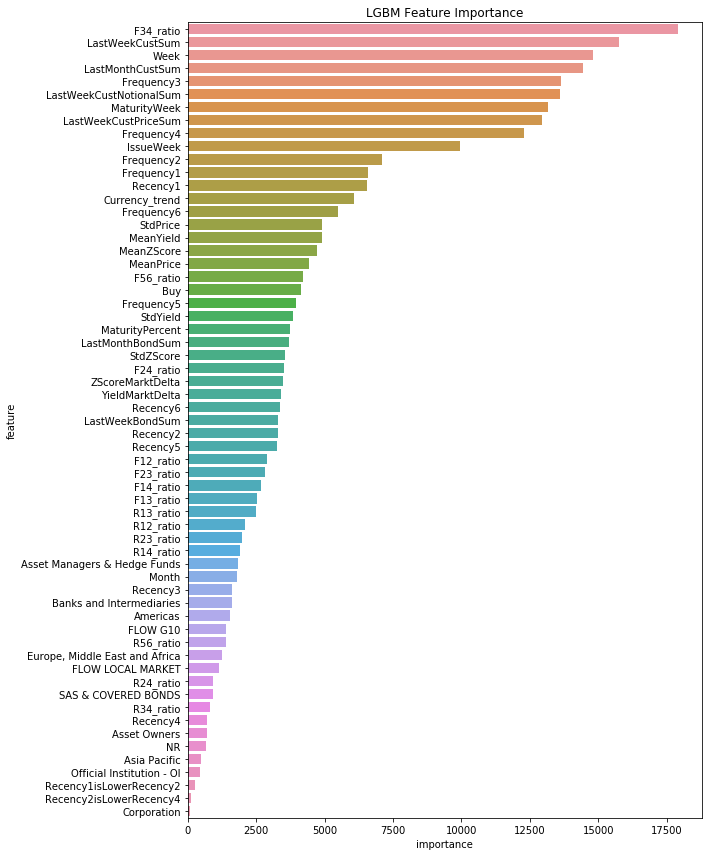

In [30]:
##### VARIABLE IMPORTANCE

# load variable importance
importance = pd.DataFrame()
importance["feature"] = features
importance["importance"] = gbm.feature_importances_

# plot variable importance
plt.figure(figsize = (10, 12))
sns.barplot(x = "importance", y = "feature", data = importance.sort_values(by = "importance", ascending = False))
plt.title('LGBM Feature Importance')
plt.tight_layout()

# save plot as pdf
#plt.savefig("../var_importance.pdf")

In [31]:
##### PREDICTION

### VALID DATA

# predict validation set
pred_valid = X_valid[["CustomerIdx", "IsinIdx", "BuySell", "Week", "CustomerInterest"]]
pred_valid["TARGET"] = gbm.predict_proba(X_valid[features], num_iteration = num_iters)[:, 1]
auc = roc_auc_score(y_valid, pred_valid.TARGET)

# check rank correlation with the best submission
best = pd.read_csv("../pred_valid/auc787625_data_v4_0_60_under_r27_wlp_lgb.csv")
best.columns = ['CustomerIdx', 'IsinIdx', 'BuySell', 'Week', 'CustomerInterest', 'TARGET_best']
best = best.merge(pred_valid[["CustomerIdx", "IsinIdx", "BuySell", "TARGET"]], 
                  how = "right", on = ["CustomerIdx", "IsinIdx", "BuySell"])
print(spearmanr(best.TARGET, best.TARGET_best))

# export CSV
pred_valid.to_csv("../pred_valid/auc" + str(round(auc, 6))[2:8] + "_" + str(data_name) + "_lgb.csv", 
                  index = False, float_format = "%.8f")


### TEST DATA

# predict test set
test["TARGET"] = gbm.predict_proba(test[features], num_iteration = num_iters)[:, 1]

# check rank correlation with the best submission
best = pd.read_csv("../submissions/auc787625_data_v4_0_60_under_r27_wlp_lgb_2stage.csv")
best = best.merge(test[["PredictionIdx", "TARGET"]], how = "left", on = "PredictionIdx")
print(spearmanr(best["TARGET"], best.CustomerInterest))

# export CSV
subm = best[["PredictionIdx", "TARGET"]]
subm.columns = ["PredictionIdx", "CustomerInterest"]
subm.to_csv("../submissions/auc" + str(round(auc, 6))[2:8] + "_" + str(data_name) + "_lgb_1stage.csv", 
            index = False, float_format = "%.8f")

SpearmanrResult(correlation=0.9800593084929927, pvalue=0.0)
SpearmanrResult(correlation=0.9458157100162355, pvalue=0.0)


# 5. MODELING - STAGE 2

In [32]:
# keep top features
#top = 100
#features = list(importance["feature"][0:np.min([top, len(features)])])

In [33]:
# use full data as train
X_train = data.loc[data.Week <= 120]
y_train = data.loc[data.Week <= 120].CustomerInterest

In [34]:
### retrain model with the best iters

# lightGBM
gbm = lgb.LGBMClassifier(n_estimators     = num_iters,
                         learning_rate    = 0.005,
                         num_leaves       = 70,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.1,
                         reg_lambda       = 0.1,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = 42,
                         num_threads      = cores)

# train lightGBM
gbm = gbm.fit(X_train[features], y_train, 
              eval_set = [(X_train[features], y_train)], 
              eval_metric = metric, verbose = 250)

[250]	valid_0's auc: 0.787951
[500]	valid_0's auc: 0.792852
[750]	valid_0's auc: 0.796824
[1000]	valid_0's auc: 0.799817
[1250]	valid_0's auc: 0.802446
[1500]	valid_0's auc: 0.80469
[1750]	valid_0's auc: 0.806561
[2000]	valid_0's auc: 0.808214
[2250]	valid_0's auc: 0.809725
[2500]	valid_0's auc: 0.811053
[2750]	valid_0's auc: 0.812287
[3000]	valid_0's auc: 0.81347
[3250]	valid_0's auc: 0.814659
[3500]	valid_0's auc: 0.815741
[3750]	valid_0's auc: 0.816677
[4000]	valid_0's auc: 0.817639


In [35]:
# predict test set
test["TARGET"] = gbm.predict_proba(test[features], num_iteration = num_iters)[:, 1]

In [36]:
# check rank correlation with the best submission
best = pd.read_csv("../submissions/auc787625_data_v4_0_60_under_r27_wlp_lgb_2stage.csv")
best = best.merge(test[["PredictionIdx", "TARGET"]], how = "left", on = "PredictionIdx")
spearmanr(best["TARGET"], best.CustomerInterest)

SpearmanrResult(correlation=0.9484095323327751, pvalue=0.0)

In [37]:
# export CSV
subm = best[["PredictionIdx", "TARGET"]]
subm.columns = ["PredictionIdx", "CustomerInterest"]
subm.to_csv("../submissions/auc" + str(round(auc, 6))[2:8] + "_" + str(data_name) + "_lgb_2stage.csv", 
            index = False, float_format = "%.8f")

# 1. SETTINGS

In [38]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr
import lightgbm as lgb
import random

In [39]:
# garbage collection
import gc
gc.enable()

In [40]:
# warnings
import warnings
warnings.filterwarnings("ignore")

In [41]:
# pandas options
pd.set_option("display.max_columns", None)

# 2. IMPORT

In [42]:
# data name (used for saving files too)
data_name = "data_v4_0_60_under"

In [43]:
# import datasets
data = pd.read_csv("../data/prepared/" + str(data_name) + ".csv", compression = "gzip")

In [44]:
# data name (used for saving files too)
data_name = "data_v4_0_60_under_r27_wlp_lm_bm_fr"

In [45]:
# drop high recency from train
data = data[(data.Week == 121) | (data.Recency2 < 27)]
data = data[(data.Week == 121) | (data.Recency1 < data.Recency1.max())]
print(data.shape)

(1696710, 45)


# 3. PREPARATIONS

### ADD MORE FEATURES

In [46]:
# compute BuySell dummy
data["Buy"] = 0
data["Buy"][data.BuySell == "Buy"] = 1
print(data.shape)

(1696710, 45)


In [47]:
### RF Ratios

#data["R12_ratio"] = data.Recency1 / data.Recency2
#data["R13_ratio"] = data.Recency1 / data.Recency3
#data["R14_ratio"] = data.Recency1 / data.Recency4
#data["R23_ratio"] = data.Recency2 / data.Recency3
#data["R24_ratio"] = data.Recency2 / data.Recency4
#data["R34_ratio"] = data.Recency3 / data.Recency4
#data["R56_ratio"] = data.Recency5 / data.Recency6

#data["F12_ratio"] = data.Frequency1 / data.Frequency2
#data["F13_ratio"] = data.Frequency1 / data.Frequency3
#data["F14_ratio"] = data.Frequency1 / data.Frequency4
#data["F23_ratio"] = data.Frequency2 / data.Frequency3
#data["F24_ratio"] = data.Frequency2 / data.Frequency4
data["F34_ratio"] = data.Frequency3 / data.Frequency4
data["F56_ratio"] = data.Frequency5 / data.Frequency6

print(data.shape)

(1696710, 47)


In [48]:
### ADD LAST WEEK SUMS

# add last week sum (CUST)
tmp = data.sort_values(by = ["Week"], ascending = True).groupby(["CustomerIdx", "Week"], as_index = True)
tmp = tmp.CustomerInterest.sum().reset_index()
tmp.columns = ["CustomerIdx", "Week", "LastWeekCustSum"]
tmp["Week"] = tmp.Week + 1
data = data.merge(tmp, how = "left", on = ["CustomerIdx", "Week"])
print(data.shape)

# add last week sum (BOND)
tmp = data.sort_values(by = ["Week"], ascending = True).groupby(["IsinIdx", "Week"], as_index = True)
tmp = tmp.CustomerInterest.sum().reset_index()
tmp.columns = ["IsinIdx", "Week", "LastWeekBondSum"]
tmp["Week"] = tmp.Week + 1
data = data.merge(tmp, how = "left", on = ["IsinIdx", "Week"])
print(data.shape)

(1696710, 48)
(1696710, 49)


In [49]:
### ADD PRICE AND NOTIONAL

tmp = pd.read_csv("../data/prepared/price_notional.csv", compression = "gzip")

# add last week price sum (CUST)
tmp2 = tmp.sort_values(by = ["Week"], ascending = True).groupby(["CustomerIdx", "Week"], as_index = True)
tmp2 = tmp2.Price.sum().reset_index()
tmp2.columns = ["CustomerIdx", "Week", "LastWeekCustPriceSum"]
tmp2["Week"] = tmp2.Week + 1
data = data.merge(tmp2, how = "left", on = ["CustomerIdx", "Week"])
print(data.shape)

# add last week notional sum (CUST)
tmp2 = tmp.sort_values(by = ["Week"], ascending = True).groupby(["CustomerIdx", "Week"], as_index = True)
tmp2 = tmp2.NotionalEUR.sum().reset_index()
tmp2.columns = ["CustomerIdx", "Week", "LastWeekCustNotionalSum"]
tmp2["Week"] = tmp2.Week + 1
data = data.merge(tmp2, how = "left", on = ["CustomerIdx", "Week"])
print(data.shape)

(1696710, 50)
(1696710, 51)


In [50]:
### ADD CUSTOMER INDICATORS

#cust  = pd.read_csv("../data/raw/Customer.csv")
#cust.head()

# create dummies for customers
#cust_dummies = pd.concat([cust.CustomerIdx, pd.get_dummies(cust.Subsector)], axis = 1)

# merge customer dummies
#data = data.merge(cust_dummies, on = "CustomerIdx", how = "left")
#print(data.shape)

In [51]:
### ADD BOND FEATURES [V1]

# load bond data
#bond_stat = pd.read_csv("../data/prepared/bondstat1_AK")

# merge bond data
#data = data.merge(bond_stat[["IsinIdx", "t", "timeOnMarket", "percentoflifeleft"]], how = "left", on = "IsinIdx")
#print(data.shape)

In [52]:
### ADD NEW BOND FEATURES [V2]

# load bond data
#bond_stat = pd.read_csv("../data/prepared/bondstat2_AK")

# merge bond data
#data = data.merge(bond_stat[["IsinIdx", 'ymeansq', 'ymeancube', 'zmeansq', 'zmeancube',
#                             'years_tomaturity', 'count', 'ratingspread', 'ratingZspread']], 
#                  how = "left", on = "IsinIdx")
#print(data.shape)

In [53]:
### ADD BOND FEATURES [V3]

# load bond data
#bond_stat = pd.read_csv("../data/prepared/bondstat3_AK")
#bond_stat.head()

# merge bond data
#data = data.merge(bond_stat[["IsinIdx", 'predyield', 'predprice']], how = "left", on = "IsinIdx")
#print(data.shape)

In [54]:
### BOND-SPECIFIC FINANCIAL INDICATORS

#bond  = pd.read_csv("../data/raw/Isin.csv")

# create bond dummies
#bond_dummies = pd.concat([bond.IsinIdx,
#                          pd.get_dummies(bond.IndustrySector), 
#                          pd.get_dummies(bond.Region),
#                          pd.get_dummies(bond.MarketIssue), 
#                          pd.get_dummies(bond.CouponType)], axis = 1)

# merge bond dummies
#data = data.merge(bond_dummies, on = "IsinIdx", how = "left")
#print(data.shape)

In [55]:
### ADD NEW NIKITA FEATURES

# import data
#cust    = pd.read_csv("../data/prepared/cust_nik.csv",   compression = "gzip")
#bond    = pd.read_csv("../data/prepared/bond_nik.csv",   compression = "gzip")
#market  = pd.read_csv("../data/prepared/data_market_v1.csv", compression = "gzip")

#cust = cust[["CustomerIdx", "Region"]]
#bond = bond[["IsinIdx", "ActualMaturityDateKey", "IssueDateKey"]]

# merge data
#print(data.shape)
#data = data.merge(cust, on = "CustomerIdx", how = "left")
#print(data.shape)
#data = data.merge(bond, on = "IsinIdx", how = "left")
#print(data.shape)
#data = data.merge(market, on = ["IsinIdx", "Week"], how = "left")
#print(data.shape)

# compute day differences
#data["ActualMaturityDateKey"] = data["ActualMaturityDateKey"] - data["Week"]
#data["IssueDateKey"]          = data["IssueDateKey"] - data["Week"]

In [56]:
### ADD LAST MONTH SUMS

# merge month number
tmp = pd.read_csv("../data/raw/Trade.csv")[["TradeDateKey"]]
tmp = tmp.drop_duplicates()
tmp["TradeDateKey"] = pd.to_datetime(tmp["TradeDateKey"], format = '%Y%m%d')
tmp["Week"] = (tmp.TradeDateKey.dt.year - 2016) * 52 + (tmp.TradeDateKey.dt.week)
tmp["CumMonth"] = (tmp.TradeDateKey.dt.year - 2016) * 12 + (tmp.TradeDateKey.dt.month)
tmp = tmp[["Week", "CumMonth"]]
tmp = tmp.drop_duplicates()
tmp = tmp.groupby("Week").CumMonth.min().reset_index()
data = data.merge(tmp, how = "left", on = "Week")
data["CumMonth"][data.Week == 121] = 28

# add last month mean (CUST)
tmp = data.sort_values(by = ["CumMonth"], ascending = True).groupby(["CustomerIdx", "CumMonth"], as_index = True)
tmp = tmp.CustomerInterest.sum().reset_index()
tmp.columns = ["CustomerIdx", "CumMonth", "LastMonthCustSum"]
tmp["CumMonth"] = tmp.CumMonth + 1
data = data.merge(tmp, how = "left", on = ["CustomerIdx", "CumMonth"])
print(data.shape)

# add last month mean (BOND)
tmp = data.sort_values(by = ["CumMonth"], ascending = True).groupby(["IsinIdx", "CumMonth"], as_index = True)
tmp = tmp.CustomerInterest.sum().reset_index()
tmp.columns = ["IsinIdx", "CumMonth", "LastMonthBondSum"]
tmp["CumMonth"] = tmp.CumMonth + 1
data = data.merge(tmp, how = "left", on = ["IsinIdx", "CumMonth"])
print(data.shape)

# drop month
del data["CumMonth"]

(1696710, 53)
(1696710, 54)


In [57]:
### ADD BOND MATURITY DATA

# import
bond = pd.read_csv("../data/prepared/data_bond_v1.csv", compression = "gzip")
bond = bond[['IsinIdx', 'MaturityWeek', 'IssueWeek']]

# merge
data = data.merge(bond, on = "IsinIdx", how = "left")

# compute week differences
data["MaturityWeek"]    = data.MaturityWeek - data.Week
data["IssueWeek"]       = data.Week - data.IssueWeek
data["MaturityPercent"] = (data.Week - data.IssueWeek) / (data.MaturityWeek - data.IssueWeek)
print(data.shape)

(1696710, 56)


In [58]:
### MERGE WEEKLY MACRO VARIABLES

# import
#fx1   = pd.read_csv("../data/prepared/data_fx1_v1.csv",  compression = "gzip")
#fx2   = pd.read_csv("../data/prepared/data_fx2_v1.csv",  compression = "gzip")
#ind1  = pd.read_csv("../data/prepared/data_ind1_v1.csv", compression = "gzip")
#ind2  = pd.read_csv("../data/prepared/data_ind2_v1.csv", compression = "gzip")

# merge currency
#bond = pd.read_csv("../data/raw/Isin.csv")
#data = data.merge(bond[["IsinIdx", "Currency"]], on = "IsinIdx")

# merge macro data
#data = data.merge(fx1,  how = 'left', on = ["Week",  "Currency"])
#print(data.shape)
#data = data.merge(fx2,  how = 'left', on = ["Month", "Currency"])
#print(data.shape)
#data = data.merge(ind1, how = 'left', on = "Week")
#print(data.shape)
#data = data.merge(ind2, how = 'left', on = "Month")
#print(data.shape)

# there are a few currencies for which we don't have info, e.g. CNH
#data[fx1.columns] = data[fx1.columns].fillna(0)
#data[fx2.columns] = data[fx2.columns].fillna(0)

# remove currency
#data.drop("Currency", axis = 1, inplace = True)
#print(data.shape)

In [59]:
### ADD NEW WEEKLY AND MONTHLY MARKET FEATURES

# merge month number
#tmp = pd.read_csv("../data/raw/Trade.csv")[["TradeDateKey"]]
#tmp = tmp.drop_duplicates()
#tmp["TradeDateKey"] = pd.to_datetime(tmp["TradeDateKey"], format = '%Y%m%d')
#tmp["Week"] = (tmp.TradeDateKey.dt.year - 2016) * 52 + (tmp.TradeDateKey.dt.week)
#tmp["CumMonth"] = (tmp.TradeDateKey.dt.year - 2016) * 12 + (tmp.TradeDateKey.dt.month)
#tmp = tmp[["Week", "CumMonth"]]
#tmp = tmp.drop_duplicates()
#tmp = tmp.groupby("Week").CumMonth.min().reset_index()
#data = data.merge(tmp, how = "left", on = "Week")
#data["CumMonth"][data.Week == 121] = 28

# import data
#market  = pd.read_csv("../data/prepared/data_market_v1.csv", compression = "gzip")
#market = market.rename(columns = {"Month": "CumMonth"})
#market.CumMonth = market.groupby(["IsinIdx", "Week"]).CumMonth.min()
#keep = market[["IsinIdx", "Week", "CumMonth"]].drop_duplicates().index
#market = market[market.index.isin(keep)]
#data = data.merge(market, how = "left", on = ["IsinIdx", "Week", "CumMonth"])
#del data["CumMonth"]
#print(data.shape)

### CHECKS AND PREPARATIONS

In [60]:
# check data
print("Dimensions:", data.shape)
data.head()

Dimensions: (1696710, 56)


,PredictionIdx,CustomerIdx,IsinIdx,BuySell,CustomerInterest,Week,Recency1,Recency2,Recency3,Recency4,Recency5,Recency6,Recency1isLowerRecency2,Recency2isLowerRecency4,Frequency1,Frequency2,Frequency3,Frequency4,Frequency5,Frequency6,Frequecny1isLowerFrequency2,Frequecny2isLowerFrequency4,Month,Buy,Asset Managers & Hedge Funds,Asset Owners,Banks and Intermediaries,Corporation,Official Institution - OI,Americas,Asia Pacific,"Europe, Middle East and Africa",FLOW G10,FLOW LOCAL MARKET,SAS & COVERED BONDS,NR,Currency_trend,MeanPrice,StdPrice,MeanYield,StdYield,MeanZScore,StdZScore,YieldMarktDelta,ZScoreMarktDelta,F34_ratio,F56_ratio,LastWeekCustSum,LastWeekBondSum,LastWeekCustPriceSum,LastWeekCustNotionalSum,LastMonthCustSum,LastMonthBondSum,MaturityWeek,IssueWeek,MaturityPercent
0,NaN,2554,12022,Sell,0.0,68,2.0,2.0,1.0,1.0,2.0,2.0,1,0,0.014925,0.029851,43.716418,80.791045,0.134328,0.208955,1,1,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1.00000,117.319623,4.613998,4.468827,0.354249,2.207733,0.545221,1.418700,0.584150,0.541105,0.642857,21.0,0.0,5.224483e+03,7.224512e+07,143.0,NaN,930,630,-1.873333
1,NaN,2107,5204,Sell,0.0,73,2.0,2.0,1.0,1.0,1.0,1.0,1,0,0.027778,0.027778,9.500000,21.541667,0.319444,0.777778,1,1,12,0,1,0,0,0,0,1,0,0,0,1,0,0,1.00000,110.170463,2.443280,5.958544,0.341985,3.637930,0.340257,2.908417,2.014346,0.441006,0.410714,1.0,4.0,5.547505e+03,3.071459e+07,22.0,1.0,464,6,0.146288
2,NaN,1790,26478,Buy,0.0,108,17.0,17.0,1.0,1.0,2.0,1.0,1,0,0.018692,0.028037,3.906542,6.925234,0.570093,0.785047,1,1,4,1,0,0,1,0,0,0,0,1,1,0,0,0,0.00724,99.357203,0.285975,0.765647,0.063911,0.490065,0.045141,-2.284480,-1.133518,0.564103,0.726190,9.0,1.0,1.314014e+03,7.444974e+06,12.0,7.0,243,17,0.402655
3,NaN,2743,6190,Sell,0.0,77,21.0,21.0,1.0,1.0,2.0,1.0,1,0,0.026316,0.026316,42.842105,105.802632,0.671053,1.250000,1,1,10,0,1,0,0,0,0,0,0,1,1,0,0,0,1.00000,99.616323,0.229460,1.449773,0.390366,0.133392,0.138246,-1.600354,-1.490191,0.404925,0.536842,59.0,1.0,1.388838e+04,1.785629e+08,347.0,7.0,47,215,0.821429
4,NaN,1856,14841,Sell,0.0,112,1.0,1.0,1.0,1.0,1.0,1.0,1,1,0.018018,0.027027,177.225225,305.396396,0.720721,1.306306,1,1,3,0,1,0,0,0,0,1,0,0,0,1,0,0,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.580312,0.551724,301.0,4.0,1.041630e+06,9.114264e+08,1212.0,6.0,47,213,0.608434


In [61]:
# check NA in the whole data
nas = data.isnull().sum()
nas[nas > 0].sort_values(ascending = False).head(20)

PredictionIdx              1211952
CustomerInterest            484758
LastWeekBondSum             429587
LastMonthBondSum            130851
StdPrice                     96696
StdYield                     96696
StdZScore                    96696
MeanZScore                   96601
MeanPrice                    96601
MeanYield                    96601
YieldMarktDelta              96601
ZScoreMarktDelta             96601
LastWeekCustPriceSum         68858
LastWeekCustNotionalSum      68858
LastWeekCustSum              53996
LastMonthCustSum             28329
MaturityPercent                  1
dtype: int64

In [62]:
# check NA in test data
nas = data[data.Week == 121].isnull().sum()
nas[nas > 0].sort_values(ascending = False).head(20)

CustomerInterest           484758
LastWeekBondSum            129728
LastMonthBondSum            32234
LastWeekCustNotionalSum     24032
LastWeekCustPriceSum        24032
LastWeekCustSum             14922
StdZScore                    5476
StdYield                     5476
StdPrice                     5476
ZScoreMarktDelta             5414
YieldMarktDelta              5414
MeanZScore                   5414
MeanYield                    5414
MeanPrice                    5414
LastMonthCustSum             4362
dtype: int64

In [63]:
# list of features
excluded_features = ["PredictionIdx", "CustomerIdx", "IsinIdx", "BuySell", "CustomerInterest",
                     "Frequecny1isLowerFrequency2", "Frequecny2isLowerFrequency4"]
features = [var for var in data.columns if var not in excluded_features]
len(features)

49

In [64]:
### DATA PARTITIONING

# training
X_train = data.loc[data.Week < 120]
y_train = data.loc[data.Week < 120].CustomerInterest

# validation
X_valid = data.loc[data.Week == 120]
y_valid = data.loc[data.Week == 120].CustomerInterest

# test set
test = data.loc[data.Week == 121]

# 4. MODELING - STAGE 1

In [65]:
### PARAMETERS

# parallel settings
cores = 10

# learner settings
metric   = "auc"
verbose  = 250
stopping = 100

# lightGBM
gbm = lgb.LGBMClassifier(n_estimators     = 10000,
                         learning_rate    = 0.005,
                         num_leaves       = 70,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.1,
                         reg_lambda       = 0.1,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = 42,
                         num_threads      = cores)

In [66]:
# train lightGBM
gbm = gbm.fit(X_train[features], y_train, 
              eval_set = [(X_train[features], y_train), 
                          (X_valid[features], y_valid)], 
              eval_metric = metric, verbose = verbose, 
              early_stopping_rounds = stopping)
    
# save number of iterations
num_iters = gbm.best_iteration_  


##### RESULTS (K = 42 - v4wlp)

# full data:     0.847355 ()
# full - r27:    0.786895 (0.79244 LB)
# under data:    0.847501 (0.79385 LB)
# under - r27:   0.787625 (0.79269 LB)


##### RESULTS (K = 44 - v4wlpm_lm, added last month sums)

# full data:     0. ()
# full - r27:    0. ()
# under data:    0.847455 ()
# under - r27:   0.788729 ()


##### RESULTS (K = 47 - v4wlpm_lm_bm, added bond maturity features)

# full data:     0. ()
# full - r27:    0. ()
# under data:    0.850085 (0.79856 LB)
# under - r27:   0.791607 ()


##### RESULTS (K = 48 - v4wlpm_lm_bm_wc, added weekly currency trend)

# full data:     0. ()
# full - r27:    0. ()
# under data:    0. ()
# under - r27:   0.791504 ()


##### RESULTS (K = 57 - v4wlpm_lm_bm_wm, added weekly macro features)

# full data:     0. ()
# full - r27:    0. ()
# under data:    0.850068 ()
# under - r27:   0.786000 ()


##### RESULTS (K = 55 - v4wlp_lm_bm_mwm, added weekly and monthlz market features)

# full data:     0. ()
# full - r27:    0. ()
# under data:    0. ()
# under - r27:   0.792010 ()

Training until validation scores don't improve for 100 rounds.
[250]	valid_0's auc: 0.788352	valid_1's auc: 0.778127
[500]	valid_0's auc: 0.793151	valid_1's auc: 0.781605
[750]	valid_0's auc: 0.796934	valid_1's auc: 0.784152
[1000]	valid_0's auc: 0.799801	valid_1's auc: 0.785759
[1250]	valid_0's auc: 0.802294	valid_1's auc: 0.787296
[1500]	valid_0's auc: 0.804482	valid_1's auc: 0.788377
[1750]	valid_0's auc: 0.806296	valid_1's auc: 0.789257
[2000]	valid_0's auc: 0.808063	valid_1's auc: 0.789998
[2250]	valid_0's auc: 0.809698	valid_1's auc: 0.790827
[2500]	valid_0's auc: 0.811082	valid_1's auc: 0.791307
[2750]	valid_0's auc: 0.812392	valid_1's auc: 0.791561
[3000]	valid_0's auc: 0.813635	valid_1's auc: 0.791825
[3250]	valid_0's auc: 0.814787	valid_1's auc: 0.792
[3500]	valid_0's auc: 0.815925	valid_1's auc: 0.792167
[3750]	valid_0's auc: 0.817014	valid_1's auc: 0.792211
Early stopping, best iteration is:
[3652]	valid_0's auc: 0.81659	valid_1's auc: 0.792255


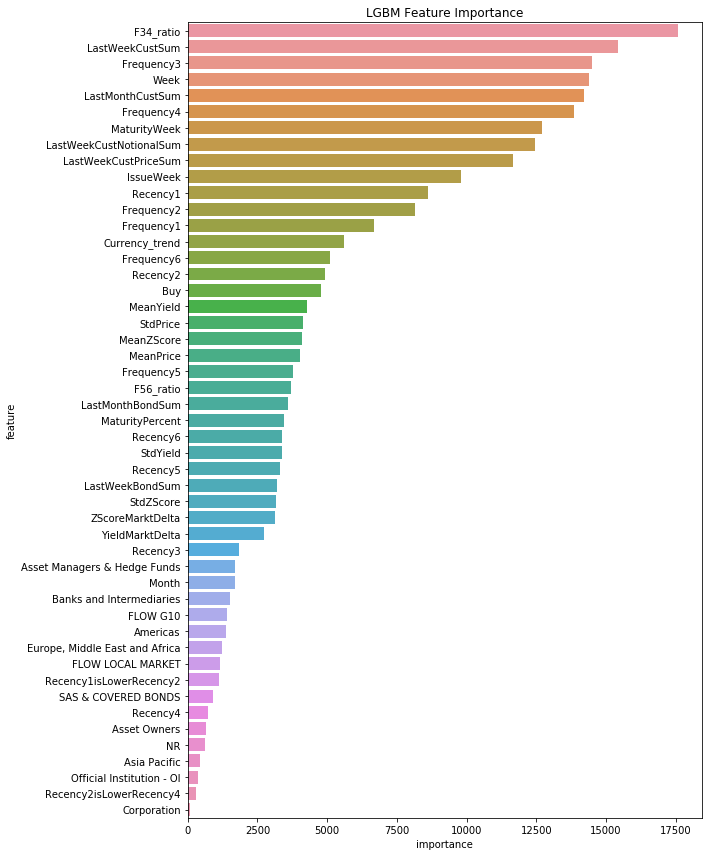

In [67]:
##### VARIABLE IMPORTANCE

# load variable importance
importance = pd.DataFrame()
importance["feature"] = features
importance["importance"] = gbm.feature_importances_

# plot variable importance
plt.figure(figsize = (10, 12))
sns.barplot(x = "importance", y = "feature", data = importance.sort_values(by = "importance", ascending = False))
plt.title('LGBM Feature Importance')
plt.tight_layout()

# save plot as pdf
#plt.savefig("../var_importance.pdf")

In [68]:
##### PREDICTION

### VALID DATA

# predict validation set
pred_valid = X_valid[["CustomerIdx", "IsinIdx", "BuySell", "Week", "CustomerInterest"]]
pred_valid["TARGET"] = gbm.predict_proba(X_valid[features], num_iteration = num_iters)[:, 1]
auc = roc_auc_score(y_valid, pred_valid.TARGET)

# check rank correlation with the best submission
best = pd.read_csv("../pred_valid/auc787625_data_v4_0_60_under_r27_wlp_lgb.csv")
best.columns = ['CustomerIdx', 'IsinIdx', 'BuySell', 'Week', 'CustomerInterest', 'TARGET_best']
best = best.merge(pred_valid[["CustomerIdx", "IsinIdx", "BuySell", "TARGET"]], 
                  how = "right", on = ["CustomerIdx", "IsinIdx", "BuySell"])
print(spearmanr(best.TARGET, best.TARGET_best))

# export CSV
pred_valid.to_csv("../pred_valid/auc" + str(round(auc, 6))[2:8] + "_" + str(data_name) + "_lgb.csv", 
                  index = False, float_format = "%.8f")


### TEST DATA

# predict test set
test["TARGET"] = gbm.predict_proba(test[features], num_iteration = num_iters)[:, 1]

# check rank correlation with the best submission
best = pd.read_csv("../submissions/auc787625_data_v4_0_60_under_r27_wlp_lgb_2stage.csv")
best = best.merge(test[["PredictionIdx", "TARGET"]], how = "left", on = "PredictionIdx")
print(spearmanr(best["TARGET"], best.CustomerInterest))

# export CSV
subm = best[["PredictionIdx", "TARGET"]]
subm.columns = ["PredictionIdx", "CustomerInterest"]
subm.to_csv("../submissions/auc" + str(round(auc, 6))[2:8] + "_" + str(data_name) + "_lgb_1stage.csv", 
            index = False, float_format = "%.8f")

SpearmanrResult(correlation=0.9808853079419136, pvalue=0.0)
SpearmanrResult(correlation=0.965716256295236, pvalue=0.0)


# 5. MODELING - STAGE 2

In [69]:
# keep top features
#top = 100
#features = list(importance["feature"][0:np.min([top, len(features)])])

In [70]:
# use full data as train
X_train = data.loc[data.Week <= 120]
y_train = data.loc[data.Week <= 120].CustomerInterest

In [71]:
### retrain model with the best iters

# lightGBM
gbm = lgb.LGBMClassifier(n_estimators     = num_iters,
                         learning_rate    = 0.005,
                         num_leaves       = 70,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.1,
                         reg_lambda       = 0.1,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = 42,
                         num_threads      = cores)

# train lightGBM
gbm = gbm.fit(X_train[features], y_train, 
              eval_set = [(X_train[features], y_train)], 
              eval_metric = metric, verbose = 250)

[250]	valid_0's auc: 0.788152
[500]	valid_0's auc: 0.792902
[750]	valid_0's auc: 0.796719
[1000]	valid_0's auc: 0.799563
[1250]	valid_0's auc: 0.802048
[1500]	valid_0's auc: 0.804294
[1750]	valid_0's auc: 0.806112
[2000]	valid_0's auc: 0.807826
[2250]	valid_0's auc: 0.809435
[2500]	valid_0's auc: 0.81086
[2750]	valid_0's auc: 0.812232
[3000]	valid_0's auc: 0.813462
[3250]	valid_0's auc: 0.814615
[3500]	valid_0's auc: 0.815758


In [72]:
# predict test set
test["TARGET"] = gbm.predict_proba(test[features], num_iteration = num_iters)[:, 1]

In [73]:
# check rank correlation with the best submission
best = pd.read_csv("../submissions/auc787625_data_v4_0_60_under_r27_wlp_lgb_2stage.csv")
best = best.merge(test[["PredictionIdx", "TARGET"]], how = "left", on = "PredictionIdx")
spearmanr(best["TARGET"], best.CustomerInterest)

SpearmanrResult(correlation=0.9694268619276096, pvalue=0.0)

In [74]:
# export CSV
subm = best[["PredictionIdx", "TARGET"]]
subm.columns = ["PredictionIdx", "CustomerInterest"]
subm.to_csv("../submissions/auc" + str(round(auc, 6))[2:8] + "_" + str(data_name) + "_lgb_2stage.csv", 
            index = False, float_format = "%.8f")